In [1]:
import csv
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import gurobipy as gp
from gurobipy import GRB
from scipy.optimize import minimize

In [2]:
def importClean_5ind(csv_file_path, desired_returns = 'Average Value Weighted Returns -- Monthly'):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées sans tenir compte de la variable T (nombre d'années).

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données filtrées.
    """

    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 10 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y%m')
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)
    df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
    df_AEWR_monthly.replace(-999, np.nan, inplace=True)
    df_AEWR_monthly.dropna(inplace=True)

    # Retourner le DataFrame complet sans filtre temporel
    df_10Ind = df_AEWR_monthly.reset_index(drop=True)
    
    return df_10Ind

In [3]:
df_48ind = importClean_5ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie B/Data/48_Industry_Portfolios.CSV', desired_returns='Average Value Weighted Returns -- Monthly')
# Set 'Date' column as the index of the DataFrame
df_48ind.set_index('Date', inplace=True)
df_48ind

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_75846/397350783.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,-8.32,-6.92,-3.53,-2.10,-4.74,-7.87,-10.15,-11.07,-3.43,-11.91,...,-3.15,-12.50,-10.09,-8.19,-9.93,-6.60,-10.18,-12.74,-9.05,-14.64
1969-08-01,4.23,4.52,5.44,6.63,3.99,6.42,11.56,9.79,4.77,2.40,...,6.08,5.59,6.38,8.21,8.98,12.76,8.80,15.06,8.89,8.38
1969-09-01,1.59,-0.58,5.28,-0.91,4.12,2.13,0.57,-0.61,-0.52,-2.64,...,1.23,-1.56,0.21,-0.75,-1.35,-2.94,7.08,-3.79,-2.54,-6.67
1969-10-01,16.95,7.97,6.84,11.64,12.42,6.28,13.57,7.59,6.41,6.72,...,3.50,4.89,11.25,6.25,9.03,10.71,5.71,4.54,10.31,3.70
1969-11-01,-1.87,-0.66,-4.91,-2.83,0.61,-8.33,-3.27,-3.97,-2.42,-2.90,...,-1.98,-7.91,-6.83,-4.08,-1.90,-8.99,-4.90,-6.23,-5.91,-2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.84,-4.28,-6.43,-5.13,-2.43,-7.38,-11.17,-6.19,-6.81,-4.41,...,-2.57,-5.15,-2.69,-6.16,-4.45,-3.92,2.57,-10.45,-3.49,-2.72
2023-10-01,-5.83,-4.98,-0.39,-4.34,-4.00,-14.31,2.77,-2.05,-0.05,4.21,...,-3.46,-6.31,-0.90,0.74,-1.71,-2.89,3.49,-9.05,-6.31,-1.77
2023-11-01,-2.29,4.26,4.79,3.90,4.76,5.66,11.08,7.90,4.97,10.63,...,10.43,12.31,7.94,6.96,7.67,13.16,3.93,9.95,13.51,6.64


In [4]:
df_number_firm = importClean_5ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie B/Data/48_Industry_Portfolios.CSV', desired_returns= 'Number of Firms in Portfolios')
# Set 'Date' column as the index of the DataFrame
df_number_firm.set_index('Date', inplace=True)

df_average_firm_size = importClean_5ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie B/Data/48_Industry_Portfolios.CSV', desired_returns='Average Firm Size')
# Set 'Date' column as the index of the DataFrame
df_average_firm_size.set_index('Date', inplace=True)

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_75846/397350783.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


### Market Cap

In [5]:
market_caps = df_average_firm_size.multiply(df_number_firm)
market_caps.dropna(inplace=True)

market_caps

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,293.6,16916.9,6142.08,3003.3,3735.82,4728.28,2214.96,4315.95,51336.92,4571.0,...,11522.6,14806.97,3010.15,33087.75,4481.12,10436.16,6617.92,1579.41,10901.25,136.8
1969-08-01,267.45,15709.85,5924.52,2937.45,3553.88,4355.9,1989.12,3838.01,49540.16,4018.0,...,11148.26,12940.99,2695.0,30332.4,4033.68,9728.46,5929.28,1377.7,9896.4,116.24
1969-09-01,278.45,16370.9,6242.04,3123.15,3656.29,4628.09,2219.04,4200.95,51800.6,4076.52,...,11786.1,13579.31,2861.1,32669.52,4394.88,10956.54,6225.75,1583.78,10742.4,126.0
1969-10-01,282.85,16231.8,6541.78,3059.55,3800.94,4717.53,2229.6,4170.13,51452.84,3958.53,...,11928.9,13345.47,2861.65,32401.2,4329.08,10573.92,6657.3,1523.06,10449.9,117.2
1969-11-01,329.05,17492.15,6988.24,3411.6,4268.11,5013.37,2530.08,4486.15,54661.88,4215.9,...,12323.98,13985.37,3182.3,34368.36,4718.56,11674.34,7018.2,1591.83,11505.15,121.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,41006.68,505297.52,346342.32,346278.68,229020.7,41627.04,394473.12,27397.08,677271.34,252346.56,...,75465.5,812140.55,519543.2,3359902.26,696424.79,2626741.91,1581703.2,68858.24,1204022.82,1219430.46
2023-10-01,41351.2,482695.72,322070.22,328411.27,219676.3,38554.32,350182.43,25643.28,630874.36,240484.16,...,73352.8,769734.55,505316.24,3152332.77,665101.66,2520866.93,1618384.68,61585.28,1159465.58,1184147.6
2023-11-01,38939.89,453495.0,320819.4,314148.67,210891.15,32941.16,359816.49,25072.2,626535.45,250580.48,...,70811.4,721091.8,497719.17,3174484.6,653520.8,2442166.45,1674202.86,55927.1,1082860.33,1162998.24


### BTOM (SUM OF BE/ SUM OF ME)

In [6]:
def importClean_5ind(csv_file_path, desired_returns = 'Average Value Weighted Returns -- Monthly'):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées sans tenir compte de la variable T (nombre d'années).

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Returns:
        DataFrame: DataFrame contenant les données filtrées.
    """

    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 10 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    df_AEWR_monthly['Date'] = df_AEWR_monthly['Date'].str.strip()
    df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y')
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)
    df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
    df_AEWR_monthly.replace(-999, np.nan, inplace=True)
    df_AEWR_monthly.dropna(inplace=True)

    # Retourner le DataFrame complet sans filtre temporel
    df_10Ind = df_AEWR_monthly.reset_index(drop=True)
    
    return df_10Ind

In [7]:
df_BtoM = importClean_5ind('/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie B/Data/48_Industry_Portfolios.CSV', 'Sum of BE / Sum of ME')
df_BtoM.set_index('Date', inplace=True)

df_BtoM = df_BtoM.loc[df_BtoM.index.repeat(12)]

df_BtoM = df_BtoM.reset_index(drop=True)
# Supprimer les lignes en excès de df_BtoM
df_BtoM = df_BtoM.iloc[:len(df_48ind)]
# Réattribuer l'index
df_BtoM.index = df_48ind.index
df_BtoM

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_75846/2496485154.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)


1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1969-07-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-08-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-09-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-10-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
1969-11-01,0.88,0.50,0.2,0.58,0.66,0.31,0.42,0.33,0.21,0.50,...,0.36,1.32,0.49,0.41,0.24,0.60,0.54,0.27,0.74,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48
2023-10-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48
2023-11-01,0.65,0.43,0.1,0.13,0.28,0.39,0.17,0.59,0.14,0.19,...,0.42,0.22,0.27,0.16,0.14,0.65,0.37,0.43,0.42,0.48


### MOM

In [8]:
df_mom = df_48ind.rolling(window=12, min_periods=12).mean()

df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)

df_mom

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-06-01,-1.608333,-1.192500,-0.079167,-0.121667,1.379167,-4.351667,-2.588333,-4.757500,-1.919167,-4.050000,...,-2.296667,-4.505000,-4.432500,-2.108333,-4.271667,-0.481667,-1.880000,-4.616667,-3.060833,-7.690833
1970-07-01,-0.982500,-0.151667,0.701667,0.616667,2.065833,-2.652500,-1.698333,-2.729167,-1.250000,-2.367500,...,-1.479167,-2.764167,-3.231667,-0.444167,-3.360833,0.620833,-0.150000,-2.749167,-1.442500,-6.460833
1970-08-01,-1.360833,-0.497500,0.105833,-0.161667,1.787500,-2.236667,-2.392500,-3.003333,-1.295833,-1.963333,...,-1.340000,-2.526667,-3.212500,-0.702500,-3.523333,0.090000,-0.750833,-3.533333,-1.712500,-5.955000
1970-09-01,-0.289167,-0.032500,0.001667,0.286667,1.486667,-1.895833,-0.841667,-2.345000,-0.720833,-0.746667,...,-1.426667,-1.650000,-1.866667,-0.072500,-2.071667,0.301667,-0.614167,-1.979167,-0.775833,-4.920000
1970-10-01,-1.998333,-0.698333,-0.209167,-0.768333,1.314167,-2.781667,-2.284167,-3.220000,-1.268333,-1.613333,...,-1.936667,-2.470000,-3.435833,-0.665833,-3.153333,-1.025833,-1.920833,-3.140000,-2.250833,-6.836667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,-0.443333,0.130833,0.800833,0.579167,1.386667,0.681667,2.873333,2.539167,1.005833,1.811667,...,1.295000,1.810000,2.147500,1.186667,1.638333,0.859167,0.887500,1.377500,1.430000,2.147500
2023-10-01,-2.074167,-1.222500,0.175000,-0.571667,0.047500,-0.840000,1.854167,1.636667,0.530000,1.255833,...,0.534167,0.715833,0.934167,1.092500,0.615000,-0.496667,0.110000,0.045833,-0.054167,1.101667
2023-11-01,-2.465833,-1.114167,-0.067500,-0.516667,-0.021667,-0.790833,2.170833,0.989167,0.159167,0.682500,...,0.526667,0.895000,1.174167,1.427500,0.755000,0.169167,0.320833,-0.030833,0.355000,1.069167


### Problème de shape dataframe MoM 

In [9]:
df_BtoM = df_BtoM.reindex(df_mom.index)
market_caps = market_caps.reindex(df_mom.index)
df_48ind = df_48ind.reindex(df_mom.index)

### Standardiser

In [10]:
# Créer un objet StandardScaler
scaler = StandardScaler()

def standardize(df):
    # Standardiser les données
    df_scaled = scaler.fit_transform(df)
    
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    return df_standardized

standardized_market_caps = standardize(market_caps)
standardized_BtoM = standardize(df_BtoM)
standardized_mom = standardize(df_mom)

In [22]:
MC = standardized_market_caps  # Capitaux de marché
BM = standardized_BtoM  # Ratio book-to-market
MOM = standardized_mom # Momentum
characteristics = [MC, BM, MOM]
# Fusionner les DataFrames de caractéristiques en un seul
characteristics_standardized_combined = pd.concat([MC, BM, MOM], axis=1)
# Vous pouvez optionnellement renommer les colonnes pour refléter les caractéristiques qu'elles représentent
new_column_names = []
for df, prefix in zip([MC, BM, MOM], ['MC', 'BM', 'MOM']):
    new_column_names.extend([f"{prefix}_{col}" for col in df.columns])
characteristics_standardized_combined.columns = new_column_names

### Calcul des coefficients de la politique de portefeuille en maximisant l'équation dans (6) et avec une utilité CRRA de coeff 5

In [23]:
M = 3 # Nombre de caractéristiques de style (Market Caps, Book-to-Market, Momentum)
N = len(df_48ind.columns) # Nombre d'actifs (48 industries)
returns = df_48ind.shift(-1).dropna() # Rendements des 48 industries
mkt_weights = market_caps / market_caps.sum(axis=1).values.reshape(-1, 1)# Poids du portefeuille de marché
mkt_weights.reset_index
mkt_weights = mkt_weights.reindex(returns.index) # Réindexer les poids du marché pour correspondre aux rendements
characteristics_standardized_combined = characteristics_standardized_combined.reindex(returns.index) # Réindexer les caractéristiques pour correspondre aux rendements
gamma = 5 # Coefficient de risque aversion
T = len(returns) # Nombre de périodes de temps

In [13]:
characteristics_standardized_combined

,MC_Agric,MC_Food,MC_Soda,MC_Beer,MC_Smoke,MC_Toys,MC_Fun,MC_Books,MC_Hshld,MC_Clths,...,MOM_Boxes,MOM_Trans,MOM_Whlsl,MOM_Rtail,MOM_Meals,MOM_Banks,MOM_Insur,MOM_RlEst,MOM_Fin,MOM_Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-06-01,-0.826856,-1.177824,-0.592256,-1.185134,-0.995842,-0.834231,-0.880046,-1.089478,-1.048672,-0.787583,...,-2.132580,-3.384300,-3.375765,-2.010064,-3.060148,-0.807418,-1.863005,-2.101533,-2.175295,-4.111958
1970-07-01,-0.823616,-1.174368,-0.593347,-1.185357,-0.993480,-0.828751,-0.879165,-1.086803,-1.055895,-0.786228,...,-1.597521,-2.312125,-2.629238,-0.963896,-2.540701,-0.189034,-0.774564,-1.355132,-1.334394,-3.497985
1970-08-01,-0.823809,-1.169331,-0.590006,-1.183689,-0.992176,-0.809309,-0.879096,-1.078076,-1.045656,-0.783683,...,-1.506435,-2.165850,-2.617322,-1.126296,-2.633374,-0.486775,-1.152582,-1.668547,-1.474689,-3.245490
1970-09-01,-0.823851,-1.169253,-0.591120,-1.184496,-0.992307,-0.789933,-0.878617,-1.073552,-1.036240,-0.781273,...,-1.563159,-1.625913,-1.780652,-0.730250,-1.805491,-0.368052,-1.066597,-1.047378,-0.987988,-2.728855
1970-10-01,-0.821928,-1.164552,-0.589004,-1.183471,-0.992164,-0.778360,-0.875637,-1.067928,-1.020951,-0.776992,...,-1.896957,-2.130949,-2.756163,-1.103245,-2.422364,-1.112637,-1.888695,-1.511340,-1.754411,-3.685588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1.237346,2.246977,2.787408,1.986062,1.248707,1.171262,2.780171,-0.495574,2.612704,2.099369,...,-0.394320,0.042142,0.362051,-0.018310,0.226674,-0.296539,-0.489870,0.213945,-0.064384,0.644669
2023-09-01,1.056529,2.050565,2.741173,1.820935,1.173850,1.149933,2.616371,-0.457871,2.539073,1.922369,...,0.218189,0.505092,0.714851,0.061318,0.310318,-0.055355,-0.121814,0.294214,0.158182,0.798994
2023-10-01,1.072439,1.902049,2.503468,1.664522,1.083847,0.992416,2.222217,-0.502349,2.277232,1.793544,...,-0.279781,-0.168803,-0.039447,0.002121,-0.273288,-0.815832,-0.610983,-0.238027,-0.613004,0.276951


In [14]:
# Define the CRRA utility function
def CRRA_utility(rp):
    return (1 + rp) ** (1 - gamma) / (1 - gamma)

gamma = 5

# Define the objective function to be maximized
def objective(theta):
    rp = [sum((mkt_weights.iloc[t, i] + (1/N) * sum(theta[j] * characteristics_standardized_combined.iloc[t, i * M + j] for j in range(M))) * returns.iloc[t, i] for i in range(N)) for t in range(T)]
    utility = sum(CRRA_utility(r) for r in rp)
    return -utility / (T) # Minimize the negative utility (equivalent to maximizing the utility)

# Initial guess for theta
theta_initial = np.zeros(M)

# Perform the optimization
result = minimize(objective, theta_initial, method='SLSQP')

# Print the optimal theta
if result.success:
    optimal_theta = result.x
    print('Optimal theta:', optimal_theta)
else:
    print('Optimization failed:', result.message)

Optimal theta: [3.60075318e+11 2.51304146e+11 4.41720423e+11]


### Calcul des Coefficients Theta optimaux 

#### Idée : estimation du theta initial par régression liénaire

In [78]:
from sklearn.linear_model import LinearRegression

def calculate_regression_coefficients(N, M, returns, characteristics_standardized_combined):

    model = LinearRegression()

    theta_initial = np.zeros((N, M))

    for i in range(N):
        y = returns.iloc[:, i]
        X = characteristics_standardized_combined.iloc[:, i*M:(i+1)*M]
        model.fit(X, y)
        theta_initial[i, :] = model.coef_

    theta_initial = theta_initial.mean(axis=0)

    return theta_initial

In [65]:
def Expanding_window_optimization(data, mkt_weights, characteristics_standardized_combined, returns):
    
    # Fonction d'utilité CRRA
    def CRRA_utility(rp, gamma=5):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)

    # Define the objective function to be maximized
    def objective(theta, mkt_weights, characteristics_standardized_combined, returns, T, N, M):
        rp = [sum((mkt_weights.iloc[t, i] + (1/N) * sum(theta[j] * characteristics_standardized_combined.iloc[t, i * M + j] for j in range(M))) * returns.iloc[t, i] for i in range(N)) for t in range(T)]
        utility = sum(CRRA_utility(r) for r in rp)
        return -utility / (T)
    
    optimal_thetas = {} # Dictionnaire pour stocker les coefficients optimaux pour chaque période
    
    start_year = data.index.min() # Date de début fixée à la première date dans les données de rendement
    
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01')
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    current_end_year = initial_end_year

    while current_end_year <= data.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        characteristics_combined_filtred = characteristics_standardized_combined.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Initial guess for theta
        #theta_initial = np.zeros(M)
        theta_initial = calculate_regression_coefficients(N, M, returns, characteristics_standardized_combined)

        # Run the optimization for the current period
        result = minimize(objective, theta_initial, args=(mkt_weights_filtred, characteristics_combined_filtred, returns_filtred, T, N, M), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_thetas[current_end_year] = result.x if result.success else None

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas

In [66]:
optimal_thetas = Expanding_window_optimization(df_48ind, mkt_weights, characteristics_standardized_combined, returns)
optimal_thetas = {key.strftime('%Y-%m-%d'): value for key, value in optimal_thetas.items()}
optimal_thetas

{'1973-12-01': array([56.37180795, 65.03130713, 63.54971279]),
 '1974-12-01': array([ 2.9130297 , -1.85123271,  0.55897016]),
 '1975-12-01': array([ 1.14654034, -0.91001579, -0.12370176]),
 '1976-12-01': array([-1.42085973, -4.75418536, -2.9913981 ]),
 '1977-12-01': array([-39.89260384, -13.32603899, -68.60176337]),
 '1978-12-01': array([-10.53527692, -20.7922841 , -13.25433198]),
 '1979-12-01': array([-10.09731186, -18.18127248, -11.89554879]),
 '1980-12-01': array([-10.98072125, -16.81589397,  -8.51662437]),
 '1981-12-01': array([ -455.49951744, -2166.04357963, -4092.08107319]),
 '1982-12-01': array([ -419.31529549, -1993.9298879 , -3766.9180036 ]),
 '1983-12-01': array([ -390.62338856, -1848.83228994, -3491.26611158]),
 '1984-12-01': array([-11551998.20804371,   8672464.94010657,   3518939.64272245]),
 '1985-12-01': array([-10810693.50736012,   8115943.11930579,   3293125.33022245]),
 '1986-12-01': array([-10158792.38919605,   7626539.50700109,   3094544.90395292]),
 '1987-12-01': a

### Visualisation des séries temporelles des thetas optimaux

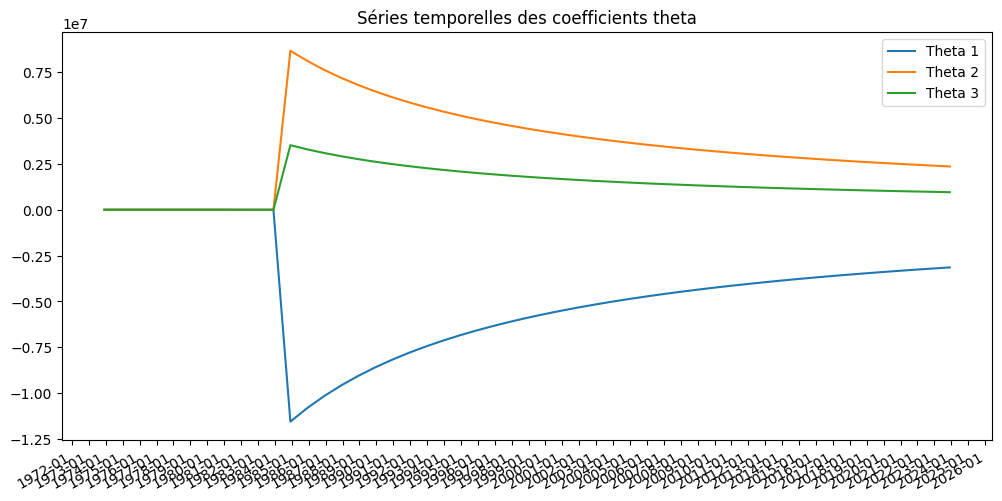

In [96]:
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Convertir les clés du dictionnaire en datetime pour le tracé
optimal_thetas_datetime = {datetime.strptime(key, '%Y-%m-%d'): value for key, value in optimal_thetas.items()}

# Convertir le dictionnaire en DataFrame
df = pd.DataFrame.from_dict(optimal_thetas_datetime, orient='index')

# Tracer chaque colonne
plt.figure(figsize=(12,6))
for i in range(df.shape[1]):
    plt.plot(df.index, df[i], label=f'Theta {i+1}')

plt.title('Séries temporelles des coefficients theta')
plt.legend()

# Format et rotation des étiquettes de l'axe des x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

### Calcul des poids de portefeuilles optimaux

In [112]:
def calculate_optimized_weights(mkt_weights, characteristics, optimal_theta):
    optimized_weights = np.zeros(N)
    
    for i in range(N):
        initial_weight = mkt_weights.iloc[i]
        adjustment = sum(optimal_theta[j] * characteristics.iloc[i * M + j] for j in range(M)) / N
        optimized_weights[i] = initial_weight + adjustment

    # Assurer la positivité des poids optimisés
    positive_weights = np.maximum(0, optimized_weights)
    # Normaliser les poids pour que leur somme soit égale à 1 comme dans l'article
    normalized_weights = positive_weights / np.sum(positive_weights)
    
    return normalized_weights

optimized_weights_monthly = {}

start_month = pd.Timestamp('1974-01-01')
filtered_months = mkt_weights[start_month:].index

for current_month in filtered_months:
    current_year = datetime(year=current_month.year, month=12, day=1)
    current_year_str = current_year.strftime('%Y-%m-%d')
    mkt_weights_for_month = mkt_weights.loc[current_month]
    characteristics_for_month = characteristics_standardized_combined.loc[current_month]
    
    # Appliquer les coefficients theta constants à travers les actifs et dans le temps
    optimized_weights = calculate_optimized_weights(mkt_weights_for_month, characteristics_for_month, optimal_thetas[current_year_str])
    
    optimized_weights_monthly[current_month] = optimized_weights

# Convertir le dictionnaire en DataFrame pour une meilleure visualisation
optimized_weights_monthly_df = pd.DataFrame.from_dict(optimized_weights_monthly, orient='index', columns=mkt_weights.columns)

In [113]:
optimized_weights_monthly_df

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.041524,0.0,...,0.024206,0.000000,0.106519,0.063939,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1974-02-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.039548,0.0,...,0.032160,0.000000,0.081755,0.060520,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1974-03-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.037976,0.0,...,0.034273,0.000000,0.080835,0.043537,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1974-04-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.041358,0.0,...,0.041408,0.000000,0.046656,0.029010,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1974-05-01,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.042477,0.0,...,0.043587,0.000000,0.008087,0.026355,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.064384,0.0,0.0,0.070986,0.0,0.170247,0.034154,0.157608,0.025445,0.0,...,0.000000,0.009140,0.000000,0.000000,0.044907,0.010071,0.000000,0.011110,0.0,0.000000
2023-09-01,0.063943,0.0,0.0,0.066892,0.0,0.166779,0.034301,0.151321,0.031071,0.0,...,0.000000,0.008193,0.000000,0.000000,0.042933,0.005331,0.002918,0.002438,0.0,0.003296
2023-10-01,0.057151,0.0,0.0,0.064578,0.0,0.163849,0.030951,0.155426,0.026340,0.0,...,0.000000,0.022894,0.000000,0.000000,0.023058,0.000000,0.000721,0.007148,0.0,0.000000
2023-11-01,0.053798,0.0,0.0,0.047371,0.0,0.149090,0.000000,0.130391,0.038445,0.0,...,0.000000,0.046258,0.000000,0.000000,0.041740,0.000000,0.000000,0.010228,0.0,0.002363


In [114]:
# Retailler le DataFrame `returns` pour qu'il corresponde aux dates de calcul des poids de portefeuille optimisés
returns_aligned = returns.reindex(optimized_weights_monthly_df.index)

In [115]:
optimized_portfolio_returns = (optimized_weights_monthly_df * returns_aligned).sum(axis=1)/100
optimized_portfolio_returns

1974-01-01    0.012438
1974-02-01   -0.024465
1974-03-01   -0.048355
1974-04-01   -0.039496
1974-05-01   -0.022140
                ...   
2023-08-01   -0.053777
2023-09-01   -0.051666
2023-10-01    0.073391
2023-11-01    0.071804
2023-12-01   -0.030827
Length: 600, dtype: float64

### Calcul des rendements du portefeuille de Benchmark (le portefeuille de marché mkt sans tilt)

In [116]:
# Calculer les rendements du portefeuille de marché (Benchmark portfolio) en utilisant les dates alignées
mkt_weights_aligned = mkt_weights.reindex(returns_aligned.index)
market_portfolio_returns = (mkt_weights_aligned * returns_aligned).sum(axis=1)/100

market_portfolio_returns

1974-01-01    0.000387
1974-02-01   -0.022024
1974-03-01   -0.045404
1974-04-01   -0.039492
1974-05-01   -0.022076
                ...   
2023-08-01   -0.048094
2023-09-01   -0.026172
2023-10-01    0.093104
2023-11-01    0.051857
2023-12-01    0.012441
Length: 600, dtype: object

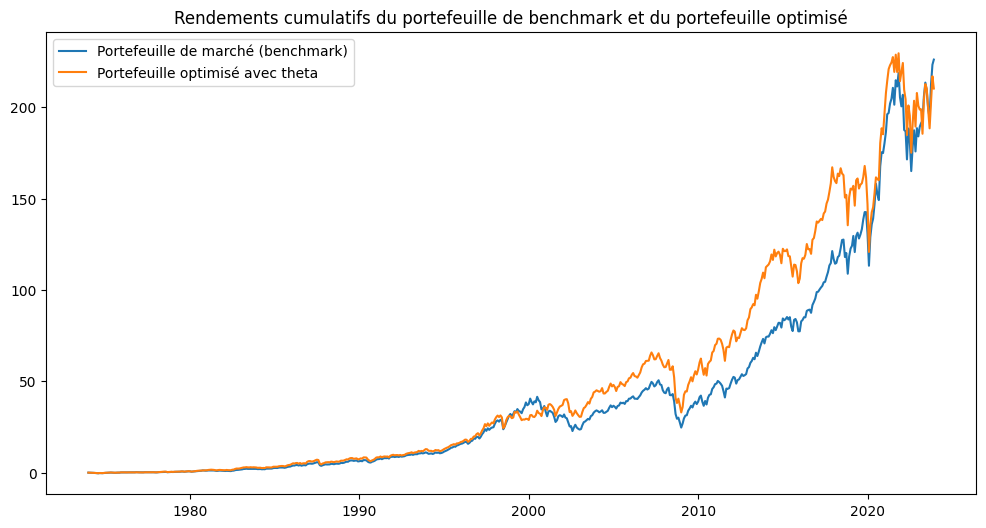

Ratio de Sharpe du portefeuille de marché (benchmark) : 0.12521219633530373
Ratio de Sharpe du portefeuille optimisé avec theta : 0.11795088045442405


In [120]:
# Calculer les rendements cumulatifs
cumulative_returns_market = (1 + market_portfolio_returns).cumprod() - 1
cumulative_returns_optimized = (1 + optimized_portfolio_returns).cumprod() - 1

# Tracer les rendements cumulatifs
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_market, label='Portefeuille de marché (benchmark)')
plt.plot(cumulative_returns_optimized, label='Portefeuille optimisé avec theta')
plt.title('Rendements cumulatifs du portefeuille de benchmark et du portefeuille optimisé')
plt.legend()
plt.show()

# Calculer les ratios de Sharpe
risk_free_rate = 0.0044
sharpe_ratio_market = (market_portfolio_returns.mean() - risk_free_rate) / market_portfolio_returns.std()
sharpe_ratio_optimized = (optimized_portfolio_returns.mean() - risk_free_rate) / optimized_portfolio_returns.std()

print(f"Ratio de Sharpe du portefeuille de marché (benchmark) : {sharpe_ratio_market}")
print(f"Ratio de Sharpe du portefeuille optimisé avec theta : {sharpe_ratio_optimized}")